In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import copy
import random
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def loadCSV(file):
    """
    Load a CSV file
    
    Parameters
    ----------
    file: string (containing .csv extension)
    
    Returns
    -------
    data: numpy array, where entries are strings
    """
    with open(file,'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        data = []
        for row in csvreader:
            data.append(row)
    return np.array(data)

def findQuestions(data):
    """
    Take input data and produce a dictionary of question titles, IDs and texts
    
    Parameters
    ----------
    data: numpy array, where entries are strings
    
    Returns
    -------
    questions: dictionary, keys = questions, keyvals = question text
    """
    
    questions = {}
    for i in range(len(data[0])):
        title = data[0][i]
        text = data[1][i]
        ID = data[2][i]
        questions.update({(ID,title) : text})
    return questions

def cleanData(data, dataStart = 3):
    """
    Create, from the raw data imported from a csv file, a useable list of dictionaries of questions & answers
    
    Parameters
    ----------
    data:                 numpy array, where entries are strings. Rows denote responses, and header row is questions.
    dataStart (optional): integer for starting row, default = 3, assuming first row(s) are headers
    
    Returns
    -------
    dataList: list of dictionaries, where index = response, key = question, keyval = answers. Allows for multiple answers to a question.
    """
    
    IDS = data[2]
    titles = data[0]
    dataList = []
    
    for i in range(dataStart,len(data)):
        responseDict = {}
        for j in range(len(data[i])):
            responseDict.update({(IDS[j],titles[j]): splitAnswer(data[i][j])})
        dataList.append(responseDict)
    return dataList

def splitAnswer(answer):
    """
    Some answers allow for mulitple responses, which are seperated by '- '
    
    Parameters
    ----------
    answer: string
    
    Returns
    -------
    parts: list of answers, where answers are strings
    """
    
    if answer == '':
        return [answer]
    parts = answer.split('- ')
    if parts[0] == '':
        parts = parts[1:]
        for i in range(len(parts)-1):
            if parts[i][-1] == ',':
                parts[i] = parts[i][:-1]
        return parts
    return parts

In [3]:
class SurveySet:
    """
    common class for all imported data sets, containing:
        - useable responses (ignoring incomplete, no consent, underage)
        - questions for data set (dictionary, where keys = QID, keyvals = [question name, question text])
        - adding "expert" fields
        - flagging questions that are seperated by ',', rather than '- '
    """
    
    importantFields = [['Finished','True'],['I have read and understood the above information and give consent for my work to be analyzed for research purposes.','Yes'],['What is your age?','18 years or older']]
    
    Q3dQuestion = [('{"ImportId":"QID74"}', 'Q3d'),['Improve or reduce the uncertainty in their measurements (e.g. more trials, more bounces)','Extend the range of their investigation (e.g. more masses, test other variables not in the equation)','Use the fit with the intercept fixed at zero and the corresponding k-value','Use the fit with the non-zero intercept and the corresponding k-value','Change the fit (or try other curve fits)','Evaluate the assumptions of the model or systematic effects (e.g. something that was missing in the model)','Check all of the measurements again','Other (please describe)']]
    Q3eQuestion = [('{"ImportId":"QID75"}', 'Q3e'),['There may have been mistakes in the data collection','There is not enough information',"The model says the intercept should be zero (and they can't add a parameter just because the fit is better)","The ideal model doesn't really apply in the real world","There was likely an assumption made in the model that wasn't valid (or something was ignored)","The intercept is irrelevant in the investigation","The intercept is due to random uncertainty (or is too small to matter)","The fit is better with the intercept fixed at zero","The fit is better with the intercept not set to zero","The uncertainty in the k-value is better with the intercept fixed at zero","Other (please describe)"]]
    Q10Question = [('{"ImportId":"QID71"}', 'Q10'),['American Indian or Alaska Native','Asian','Black or African American','Hispanic/Latino','Native Hawaiian or other Pacific Islander','White','Other race/ethnicity','Prefer not to disclose']]
    commaQuestions = {('{"ImportId":"expert"}','Expert') : ['True','False']}
    commaQuestions.update({Q3dQuestion[0] : Q3dQuestion[1]})
    commaQuestions.update({Q3eQuestion[0] : Q3eQuestion[1]})
    commaQuestions.update({Q10Question[0] : Q10Question[1]})
    
    allQuestions = {}
    allQuestions.update(commaQuestions)
    
    def __init__(self,file):
        self.file = file
        #loading and cleaning up initial responses from the folder
        rawData = loadCSV(file)
        responses = cleanData(rawData)
        self.questions = findQuestions(rawData)
        useableResponses = []
        fieldIDS = []
        #checking to see what are the IDS for the important fields
        for field in SurveySet.importantFields:
            for question in self.questions:
                if field[0] in self.questions[question]:
                    fieldIDS.append([question,field[1]])
        for response in responses:
            useResponse = True
            #seeing if response can be used
            for field in fieldIDS:
                if response[field[0]][0] == field[1]:
                    pass
                else:
                    useResponse = False
                    break
            #if the response can be used, add the expert field and seperate by comma questions that require it
            if useResponse:
                if 'expert' in self.file:
                    response.update({('{"ImportId":"expert"}','Expert') : ['True']})
                else:
                    response.update({('{"ImportId":"expert"}','Expert') : ['False']})
                for question in SurveySet.commaQuestions:
                    try:
                        mushedAnswer = response[question][0]
                        if mushedAnswer == '':
                            continue
                        response[question] = []
                        for answer in SurveySet.commaQuestions[question]:
                            if answer in mushedAnswer:
                                response[question].append(answer)
                    except KeyError:
                        pass
                useableResponses.append(response)
                for question in response:
                    if question in SurveySet.allQuestions:
                        for answer in response[question]:
                            if answer in SurveySet.allQuestions[question]:
                                pass
                            else:
                                SurveySet.allQuestions[question].append(answer)
                    else:
                        SurveySet.allQuestions.update({question : [response[question][0]]})
                        for i in range(1,len(response[question])):
                            if response[question][i] in SurveySet.allQuestions[question]:
                                pass
                            else:
                                SurveySet.allQuestions[question].append(response[question][i])
                        
        self.questions.update({('{"ImportId":"expert"}','Expert') : 'Expert'})
        self.responses = useableResponses

In [4]:
def probFunction(dataSets,question):
    """
    Create a 'dictionary function' for a given question, where keys = answers, keyvals = prob of answer
    
    Parameters
    ----------
    dataSets: list of SurveySet class data
    question: tuple question, to serve as a keyval in survey questions
    
    Returns
    -------
    xPx: dictionary, where keys = answers, keyvals = prob. of answer
    """
    
    xPx = {}
    norm = 0.0
    
    for data in dataSets:
        for response in data.responses:
            try:
                #seeing if there's along-answer version of the same question with some text
                skip = False
                for testQuestion in data.questions:
                    if testQuestion == question:
                        continue
                    if testQuestion[1] == question[1]:
                        if response[testQuestion][0] != '':
                            skip = True
                if skip:
                    continue
                    
                #if all's good, then keep going
                answer = response[question]
                for part in answer:
                    norm += 1.0
                    if part in xPx:
                        xPx[part] += 1.0
                    else:
                        xPx.update({part : 1.0})
            except KeyError:
                pass
    
    for answer in xPx:
        xPx[answer] = xPx[answer]/norm
    
    return xPx 

def jointprobFunction(dataSets,question1,question2):
    """
    Create a 'dictionary function' for a given question, where keys = answers, keyvals = prob of answer
    
    Parameters
    ----------
    dataSets:  list of SurveySet class data
    question1: tuple question, to serve as a keyval in survey questions
    question2: tuple question, to serve as a keyval in survey questions
    
    Returns
    -------
    xyPxy: dictionary, where keys = answers, keyvals = prob. of answer
    """
    
    xyPxy = {}
    norm = 0.0
    
    for data in dataSets:
        for response in data.responses:
            try:
                #seeing if there's along-answer version of one of the questions with some text
                skip = False
                for testQuestion in data.questions:
                    if (testQuestion == question1) or (testQuestion == question2):
                        continue
                    if (testQuestion[1] == question1[1]) or (testQuestion[1] == question2[1]):
                        if response[testQuestion][0] != '':
                            skip = True
                            break
                if skip:
                    continue
                    
                #if all's good, then keep going
                answer1 = response[question1]
                answer2 = response[question2]
                for part1 in answer1:
                    for part2 in answer2:
                        norm += 1.0
                        if (part1,part2) in xyPxy:
                            xyPxy[(part1,part2)] += 1.0
                        else:
                            xyPxy.update({(part1,part2) : 1.0})
            except KeyError:
                pass
    
    for answer in xyPxy:
        xyPxy[answer] = xyPxy[answer]/norm
    
    return xyPxy

def mutualInformation(xPx,yPy,xyPxy):
    """
    Calculate the mutual information between question x and question y, assuming that the prob. and joint prob. functions are pre-calculated
    
    Parameters
    ----------
    xPx,yPx,xyPxy: dictionary functions, where keys = answers, keyvals = probs
    
    Returns
    -------
    mutInfo: float, mutual info between qx and qy
    """
    
    mutInfo = 0.0
    for x in xPx:
        for y in yPy:
            try:
                mutInfo += xyPxy[(x,y)]  * (np.log(xyPxy[(x,y)]) - np.log(xPx[x]) - np.log(yPy[y]))
            except KeyError:
                pass
            
    return mutInfo

def entropy(dataSets,question):
    """
    Find the entropy of a particular question
    
    Parameters
    ----------
    dataSets:  list of SurveySet class data
    question: tuple question, to serve as a keyval in survey questions
    
    Returns
    -------
    entropy: entropy of the answers of question
    """
    xPx = probFunction(dataSets,question)
    return sum([-xPx[x]*np.log(xPx[x]) for x in xPx])

In [5]:
def plotMutualInformation(questions, plotEntropy = True):
    """
    Temp. Plot of the mutual information bewteen select questions
    
    Parameters
    ----------
    questions:   list of questions to plot
    plotEntropy: include, at the bottom of the plot, the entropy for each question
    """

    zvals = [[allMutInfo[(q1,q2)] for q1 in questions] for q2 in questions]
    if plotEntropy:
        zvals.append([allEntropy[q] for q in selectQuestions])

    xlabels = [question[1] for question in selectQuestions]
    ylabels = []
    ylabels.extend(xlabels)
    if plotEntropy:
        ylabels.extend(['entropy'])

    fig, axs = plt.subplots(figsize = (20,20))
    img = plt.imshow(zvals,interpolation='nearest',cmap='hot')
    plt.xticks([i for i in range(len(selectQuestions))],xlabels,rotation='vertical')
    plt.yticks([i for i in range(len(selectQuestions)+1)],ylabels)
    axs.xaxis.tick_top()
    fig.colorbar(img)
    plt.show()
    
def plotJointProb(q1,q2,savefig = False,figsize=(12,12)):
    """
    Plot the joint probability distribution between q1 and q2
    
    Parameters
    ----------
    q1,q2: tuple keys
    """

    xlabels = [x for x in allProbFunctions[q1]]
    ylabels = [y for y in allProbFunctions[q2]]

    zvals = np.array([[0.0 for x in xlabels] for y in ylabels])

    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            try:
                zvals[j][i] = allJointProbFunctions[(q1,q2)][(xlabels[i],ylabels[j])]
            except KeyError:
                pass


    fig, axs = plt.subplots(figsize=figsize)
    img = plt.imshow(zvals,interpolation='nearest',cmap='hot')
    plt.xticks([i for i in range(len(xlabels))],xlabels,rotation='vertical')
    plt.yticks([i for i in range(len(ylabels))],ylabels)
    axs.set_title(q2[1]+' vs '+q1[1])
    fig.colorbar(img)
    if not savefig:
        plt.show()

def plotCondProb(q1,q2,savefig = False,figsize=(12,12)):
    """
    Plot the conditionan probability distribution between q1 and q2, p(q2|q1)
    
    Parameters
    ----------
    q1,q2: tuple keys
    """

    xlabels = [x for x in allProbFunctions[q1]]
    ylabels = [y for y in allProbFunctions[q2]]

    zvals = np.array([[0.0 for x in xlabels] for y in ylabels])

    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            try:
                zvals[j][i] = allJointProbFunctions[(q1,q2)][(xlabels[i],ylabels[j])]/allProbFunctions[q1][xlabels[i]]
            except KeyError:
                pass


    fig, axs = plt.subplots(figsize=figsize)
    img = plt.imshow(zvals,interpolation='nearest',cmap='hot')
    plt.xticks([i for i in range(len(xlabels))],xlabels,rotation='vertical')
    plt.yticks([i for i in range(len(ylabels))],ylabels)
    axs.set_title(q2[1]+' given '+q1[1])
    fig.colorbar(img)
    if not savefig:
        plt.show()

In [9]:
folder = 'data_old'
surveyFiles = os.listdir(folder)
allData = [SurveySet(folder + '/' + surveyFile) for surveyFile in surveyFiles]

In [10]:
g1Questions = [('{"ImportId":"QID14_1"}', 'Q1a_1'),('{"ImportId":"QID15"}', 'Q1b'),('{"ImportId":"QID64_x18"}', 'Q1c_x18'),('{"ImportId":"QID64_x20"}', 'Q1c_x20'),('{"ImportId":"QID64_x17"}', 'Q1c_x17'),('{"ImportId":"QID64_x19"}', 'Q1c_x19'),('{"ImportId":"QID76_1"}', 'Q1d_1'),('{"ImportId":"QID18"}', 'Q1e'),('{"ImportId":"QID60_x8"}', 'Q1f_x8'),('{"ImportId":"QID60_x9"}', 'Q1f_x9'),('{"ImportId":"QID60_x5"}', 'Q1f_x5'),('{"ImportId":"QID60_x1"}', 'Q1f_x1'),('{"ImportId":"QID60_x7"}', 'Q1f_x7'),('{"ImportId":"QID60_x4"}', 'Q1f_x4'),('{"ImportId":"QID60_x11"}', 'Q1f_x11'),('{"ImportId":"QID60_x2"}', 'Q1f_x2'),('{"ImportId":"QID60_x3"}', 'Q1f_x3'),('{"ImportId":"QID60_x6"}', 'Q1f_x6'),('{"ImportId":"QID62"}', 'Q1g')]
g2Questionsp1 = [('{"ImportId":"QID20_1"}', 'Q2a_1'),('{"ImportId":"QID21"}', 'Q2b'),('{"ImportId":"QID61_x11"}', 'Q2c_x11'),('{"ImportId":"QID61_x5"}', 'Q2c_x5'),('{"ImportId":"QID61_x2"}', 'Q2c_x2'),('{"ImportId":"QID61_x8"}', 'Q2c_x8'),('{"ImportId":"QID61_x7"}', 'Q2c_x7'),('{"ImportId":"QID61_x9"}', 'Q2c_x9'),('{"ImportId":"QID61_x15"}', 'Q2c_x15'),('{"ImportId":"QID61_x4"}', 'Q2c_x4'),('{"ImportId":"QID61_x3"}', 'Q2c_x3'),('{"ImportId":"QID61_x1"}', 'Q2c_x1'),('{"ImportId":"QID61_x6"}', 'Q2c_x6'),('{"ImportId":"QID77_1"}', 'Q2d_1'),('{"ImportId":"QID23"}', 'Q2e'),('{"ImportId":"QID56_x4"}', 'Q2f_x4'),('{"ImportId":"QID56_x2"}', 'Q2f_x2'),('{"ImportId":"QID56_x8"}', 'Q2f_x8'),('{"ImportId":"QID56_x3"}', 'Q2f_x3'),('{"ImportId":"QID56_x7"}', 'Q2f_x7'),('{"ImportId":"QID56_x6"}', 'Q2f_x6'),('{"ImportId":"QID56_x1"}', 'Q2f_x1'),('{"ImportId":"QID56_x9"}', 'Q2f_x9'),('{"ImportId":"QID24"}', 'Q2g')]
g2Questionsp2 = [('{"ImportId":"QID79_1"}', 'Q3a_1'),('{"ImportId":"QID80"}', 'Q3b'),('{"ImportId":"QID81_x11"}', 'Q3c_x11'),('{"ImportId":"QID81_x5"}', 'Q3c_x5'),('{"ImportId":"QID81_x2"}', 'Q3c_x2'),('{"ImportId":"QID81_x8"}', 'Q3c_x8'),('{"ImportId":"QID81_x7"}', 'Q3c_x7'),('{"ImportId":"QID81_x9"}', 'Q3c_x9'),('{"ImportId":"QID81_x15"}', 'Q3c_x15'),('{"ImportId":"QID81_x4"}', 'Q3c_x4'),('{"ImportId":"QID81_x3"}', 'Q3c_x3'),('{"ImportId":"QID81_x1"}', 'Q3c_x1'),('{"ImportId":"QID81_x6"}', 'Q3c_x6'),('{"ImportId":"QID74"}', 'Q3d'),('{"ImportId":"QID75"}', 'Q3e')]
compQuestions = [('{"ImportId":"QID33"}', 'Q4a'),('{"ImportId":"QID34"}', 'Q4b'),('{"ImportId":"QID70_x9"}', 'Q4c_x9'),('{"ImportId":"QID70_x10"}', 'Q4c_x10'),('{"ImportId":"QID70_x6"}', 'Q4c_x6'),('{"ImportId":"QID70_x4"}', 'Q4c_x4'),('{"ImportId":"QID70_x3"}', 'Q4c_x3'),('{"ImportId":"QID70_x2"}', 'Q4c_x2'),('{"ImportId":"QID70_x1"}', 'Q4c_x1'),('{"ImportId":"QID70_x11"}', 'Q4c_x11'),('{"ImportId":"QID70_x5"}', 'Q4c_x5'),('{"ImportId":"QID70_x8"}', 'Q4c_x8'),('{"ImportId":"QID70_x7"}', 'Q4c_x7')]
demQuestions = [('{"ImportId":"QID35"}', 'Q6'),('{"ImportId":"QID36"}', 'Q7'),('{"ImportId":"QID39"}', 'Q9'),('{"ImportId":"QID71"}', 'Q10'),('{"ImportId":"expert"}', 'Expert')]

selectQuestions = []
selectQuestions.extend(g1Questions)
selectQuestions.extend(g2Questionsp1)
selectQuestions.extend(g2Questionsp2)
selectQuestions.extend(compQuestions)
selectQuestions.extend(demQuestions)

In [11]:
fillQuestions = []
fillQuestions.extend(g1Questions)
fillQuestions.extend(g2Questionsp1)
fillQuestions.extend(g2Questionsp2)
fillQuestions.extend(compQuestions)

fillData = copy.deepcopy(allData)
for data in fillData:
    for response in data.responses:
        empty = True
        for question in fillQuestions:
            if response[question] != ['']:
                empty = False
                break
        if empty:
            data.responses.remove(response)

In [15]:
for data in fillData:
    for response in data.responses:
        empty = True
        for question in fillQuestions:
            if response[question] != ['']:
                empty = False
        if empty:
            print('aaaaaahhhhh')
            data.responses.remove(response)

In [16]:
allProbFunctions = {}
for q in selectQuestions:
    allProbFunctions.update({q : probFunction(fillData,q)})

In [17]:
allJointProbFunctions = {}
for q1 in selectQuestions:
    for q2 in selectQuestions:
        allJointProbFunctions.update({(q1,q2) : jointprobFunction(fillData,q1,q2)})

In [18]:
allMutInfo = {}
for q1 in selectQuestions:
    for q2 in selectQuestions:
        allMutInfo.update({(q1,q2) : mutualInformation(allProbFunctions[q1],allProbFunctions[q2],allJointProbFunctions[(q1,q2)])})

In [19]:
allEntropy = {q : entropy(fillData,q) for q in selectQuestions}

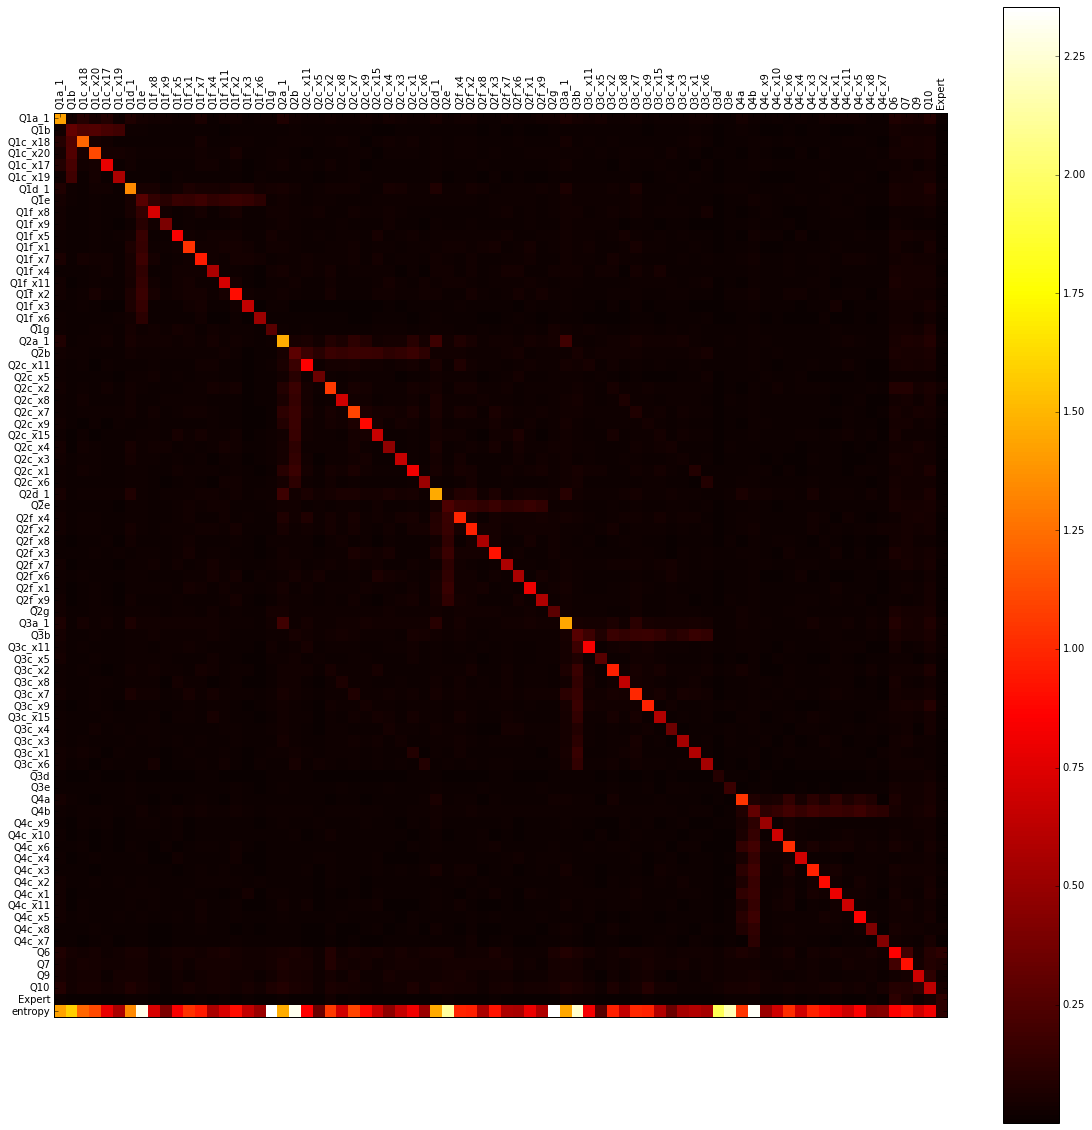

In [20]:
plotMutualInformation(selectQuestions)

CLUSTERING

In [70]:
def findInitialCenters(vecData,k):
    """
    Produce k center so start the k-means algorithm
    
    Parameters
    ----------
    vecData: 3d list, where 0: response, 1: question: 2: answer(s)
    k:       int, number of cluster centers
    
    Returns
    -------
    centers: 3d list of length k, where 0: center, 1:question, 2:answer(2)
    """
    
    c0 = random.randint(0,len(vecData))
    centers = [vecData[c0]]
    
    for i in range(1,k):
        indices = [i for i in range(len(vecData))]
        probs = [min([DEucl(vecPoint,center) for center in centers]) for vecPoint in vecData]
        probs = probs/sum(probs)
        centers.append(vecData[np.random.choice(indices,p=probs)])
    
    return centers

def findClusterCenter(cluster,data):
    """
    Find the center of a cluster of data points
    
    Parameters
    ----------
    cluster: list of responses, indexed by 0:response, 1:question, 2:answer
    data:    3d list, where 0: response, 1: question: 2: answer(s)
    
    Returns
    -------
    center: center of the cluster
    """
    
    numbPoints = len(cluster)
    if numbPoints == 0:
        return [[0.0 for answer in question] for question in data[0]]
    
    center = [list(sum([np.array(point[i]) for point in cluster])/numbPoints) for i in range(len(cluster[0]))]
    
    return center

def kMeans(data,k):
    """
    make k clusters of data
    
    Parameters
    ----------
    data: 3d list, where 0: response, 1: question: 2: answer(s)
    k:       int, number of cluster centers
    
    Returns
    -------
    clusters
    """
    centers = findInitialCenters(data,k)
    findMore = True
    kIterator = 0

    while findMore:
        centersOld = copy.deepcopy(centers)
        clusters = [[] for center in centers]
        for vecPoint in data:
            order = np.array([DEucl(vecPoint,center) for center in centers]).argsort()
            clusters[order[0]].append(vecPoint)
        centers = [findClusterCenter(cluster,data) for cluster in clusters]
        kIterator += 1
        if kIterator > 3**len(vectAllResponses):
            findMore = False
            print("didn't converge")
        if centersOld == centers:
            findMore = False
            print("converged")
    
    return (clusters,centers)

IndentationError: unindent does not match any outer indentation level (<ipython-input-70-c1c0f0ea7044>, line 73)

In [ ]:
def vectResponses(dataSets,questions):
    """
    Create vector responses for dataSets
    
    Parameters
    ----------
    dataSets:  list of SurveySet class data
    questions: list of questions of interest
    
    Returns
    -------
    vectAllResponses: 3d list, where 0: response, 1: question: 2: answer(s)
    """
    
    vectAllResponses = []
    for data in dataSets:
        for response in data.responses:
            vectResponse = []
            for question in questions:
                vectResponse.append([])
                try:
                    element = 1.0#/np.sqrt(len(response[question]))
                    for answer in SurveySet.allQuestions[question]:
                        useAnswer = False
                        for part in response[question]:
                            if part == answer:
                                useAnswer = True
                                break
                        if useAnswer:
                            vectResponse[-1].append(element)
                        else:
                            vectResponse[-1].append(0.0)
                except KeyError:
                    element = 1.0#/np.sqrt(len(SurveySet.allQuestions[question]))
                    for answer in SurveySet.allQuestions[question]:
                        vectResponse[-1].append(element)
            vectAllResponses.append(vectResponse)
    
    return vectAllResponses

def DEucl(vect1,vect2):
    """
    Find the euclidean divergence between 2 vect. responses
    
    Parameters
    ----------
    vect1,vect2: list, indexed by question
    
    Returns
    -------
    deucl: float, euclidean divergence 1/2 sum((vect1_i - vect2_i)^2)
    """
    
    deucl = 0.0
    
    if len(vect1) != len(vect2):
        return float('nan')
    
    for i in range(len(vect1)):
        deucl += 0.5*np.linalg.norm(np.array(vect1[i])-np.array(vect2[i]))**2
        
    return deucl

In [ ]:
vectAllResponses = vectResponses(fillData,fillQuestions)
dictAllResponses = []
for data in fillData:
    for response in data.responses:
        dictAllResponses.append(response)

In [ ]:
(clusters3,centers3) = kMeans(vectAllResponses,3)

In [ ]:
(clusters2,centers2) = kMeans(vectAllResponses,2)

In [ ]:
for cluster in clusters2:
    print(len(cluster))

In [ ]:
for cluster in clusters:
    print(len(cluster))

In [ ]:
vectDistances = [[DEucl(point1,point2) for point1 in vectAllResponses] for point2 in vectAllResponses]

In [ ]:
tse = manifold.TSNE(n_components=3,metric='precomputed')
TSNEprojections = tse.fit_transform(vectDistances).T

In [ ]:
vectAllResponsesFlatten = np.array([[answer for question in r for answer in question] for r in vectAllResponses])
avg = sum(vectAllResponsesFlatten/len(vectAllResponsesFlatten))
vectAllResponsesFlatten = vectAllResponsesFlatten - avg
u, s, vt = np.linalg.svd(vectAllResponsesFlatten)
SVDprojections = u*s

In [ ]:
s = []
for response in dictAllResponses:
    if response[('{"ImportId":"expert"}', 'Expert')][0] == 'True':
        s.append(500)
    else:
        s.append(100)
c3 = []
for point in vectAllResponses:
    if point in clusters3[0]:
        c3.append('red')
    elif point in clusters3[1]:
        c3.append('blue')
    elif point in clusters3[2]:
        c3.append('green')
c2 = []
for point in vectAllResponses:
    if point in clusters2[0]:
        c2.append('red')
    elif point in clusters2[1]:
        c2.append('blue')

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(SVDprojections[:,0],SVDprojections[:,1],s=s,c=c2)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(SVDprojections[:,0],SVDprojections[:,1],s=s,c=c2)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.scatter(TSNEprojections[0],TSNEprojections[1],s=s,c=c3)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
[px,py,pz] = [SVDprojections[:,0],SVDprojections[:,1],SVDprojections[:,2]]

Xdist = px.max() - px.min()
Xcntr = (px.max() + px.min())/2.0
Ydist = py.max() - py.min()
Ycntr = (py.max() + py.min())/2.0
Zdist = pz.max() - pz.min()
Zcntr = (pz.max() + pz.min())/2.0
dist = 0.6*max(Xdist,Ydist,Zdist)

ax = fig.gca(projection='3d')
im = ax.scatter(px,py,pz,s=s,c=c3)
ax.set_xlim([Xcntr - dist, Xcntr + dist])
ax.set_ylim([Ycntr - dist, Ycntr + dist])
ax.set_zlim([Zcntr - dist, Zcntr + dist])

ax.set_axis_off()

for ii in np.arange(0,360,5):
    ax.view_init(elev=10., azim=float(ii))
    plt.savefig("3clusters/%03d.png" % ii)

plt.show()

In [ ]:
plt.close()

Diff Vector Representation

In [57]:
def largesmallreasonableTofloat(answer):
    """
    Turn answer into float for 'small', 'good', 'bad', 'bad in other ways' questions
    """
    possibleAnswers = ['Other','Is small','','Is reasonable','Is large']
    
    for i in range(len(possibleAnswers)):
        if answer == possibleAnswers[i]:
            return float(i-2)
        
    return 0.0

def smallgoodbadToFloat(answer):
    """
    Turn answer for 'small', 'good', 'bad', 'bad in other ways' questions to a float
    """
    
    possibleAnswers = ['Was bad in other ways','Was too small (or there were too few)','Was good','Was too big (or there were too many)']
    
    for i in range(len(possibleAnswers)):
        if answer == possibleAnswers[i]:
            return float(i-2)
        
    return 0.0

def groupcompTofloat(answer):
    """
    Turn answer about a group 1/2 comparason to a float
    """
    
    if 'Group 1' in answer:
        return -1.0
    
    if 'Group 2' in answer:
        return 1.0
    
    if 'Both' in answer:
        return 0.0
    
    return 0.0

In [58]:
#finding numerical questions
"""numQuestions = []
for q in SurveySet.allQuestions:
    for answer in SurveySet.allQuestions[q]:
        if answer == '':
            continue
        try:
            float(answer)
            numQuestions.append(q)
            break
        except ValueError:
            break
            """
#finding 'Is small', 'Is large', 'Is reasonable' questions
possibleAnswers = ['Is small','Is reasonable','Is large']
largesmallreasonableQuestions = []
for q in SurveySet.allQuestions:
    for answer in SurveySet.allQuestions[q]:
        if answer == '':
            continue
        if answer in possibleAnswers:
            largesmallreasonableQuestions.append(q)
            break
        else:
            break
#finding 'small', 'good', 'bad', 'bad in other ways' questions
possibleAnswers = ['Was good','Was too big (or there were too many)','Was too small (or there were too few)','Was bad in other ways']
smallgoodbadQuestions = []
for q in SurveySet.allQuestions:
    for answer in SurveySet.allQuestions[q]:
        if answer == '':
            continue
        if answer in possibleAnswers:
            smallgoodbadQuestions.append(q)
        break
#finding group comparison questions
possibleAnswers = ['Was better for Group 1','Was better for Group 2','Was equally good for both groups']
groupcompQuestions = [('{"ImportId":"QID33"}','Q4a')]
for q in SurveySet.allQuestions:
    for answer in SurveySet.allQuestions[q]:
        if answer == '':
            continue
        if answer in possibleAnswers:
            groupcompQuestions.append(q)
        break

In [59]:
for q in numQuestions:
    for data in allData:
        if q in data.questions:
            pass
        else:
            print('still removing...')
            numQuestions.remove(q)
            break
            
for q in largesmallreasonableQuestions:
    for data in allData:
        if q in data.questions:
            pass
        else:
            print('still removing...')
            largesmallreasonableQuestions.remove(q)
            break
            
for q in smallgoodbadQuestions:
    for data in allData:
        if q in data.questions:
            pass
        else:
            print('still removing...')
            largesmallreasonableQuestions.remove(q)
            break
            
for q in groupcompQuestions:
    for data in allData:
        if q in data.questions:
            pass
        else:
            print('still removing...')
            groupcompQuestions.remove(q)
            break

In [60]:
numResponseVect = []
for data in fillData:
    for response in data.responses:
        vectR = []
        for q in numQuestions:
            answer = response[q][0]
            if answer == '':
                vectR.append(0.0)
            else:
                vectR.append(float(answer))
        for q in largesmallreasonableQuestions:
            vectR.append(largesmallreasonableTofloat(response[q][0]))
        for q in smallgoodbadQuestions:
            vectR.append(smallgoodbadToFloat(response[q][0]))
        for q in groupcompQuestions:
            vectR.append(groupcompTofloat(response[q][0]))
        numResponseVect.append(vectR)
numResponseVect = np.array(numResponseVect)

8

In [61]:
respAvg = sum(numResponseVect)/len(numResponseVect)
numResponseVect = numResponseVect - respAvg
u,s,vt = np.linalg.svd(numResponseVect)

In [62]:
SVDproj = np.dot(numResponseVect,vt.T)

In [100]:
len(SVDproj)

412

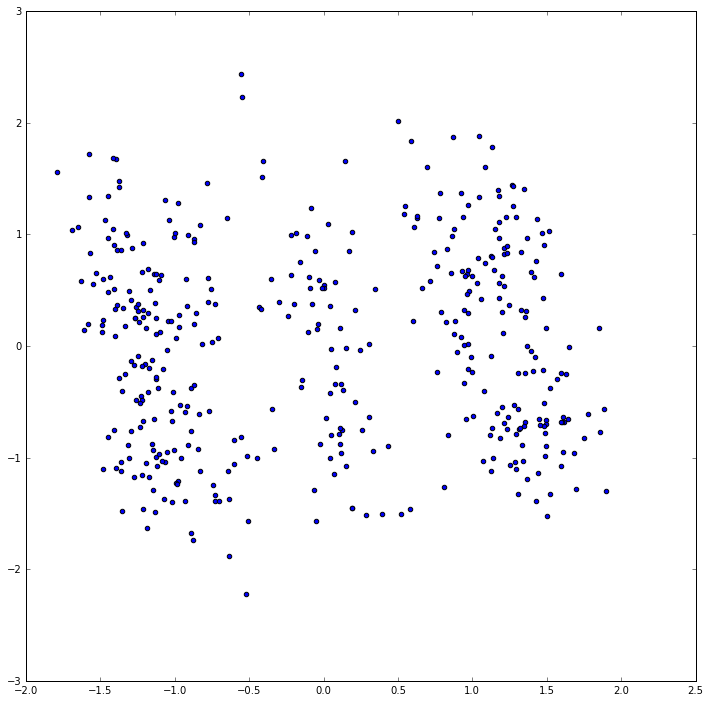

In [63]:
plt.figure(figsize=(12,12))
plt.scatter(SVDproj[:,0],SVDproj[:,1])
plt.show()

In [133]:
def findInitialCenters(vecData,k):
    """
    Produce k center so start the k-means algorithm
    
    Parameters
    ----------
    vecData: list, where 0: response, 1:answer
    k:       int, number of cluster centers
    
    Returns
    -------
    centers: 3d list of length k, where 0: center, 1:question, 2:answer(2)
    """
    
    c0 = random.randint(0,len(vecData))
    centers = [vecData[c0]]
    
    for i in range(1,k):
        indices = [i for i in range(len(vecData))]
        probs = [min([np.linalg.norm(vecPoint-center) for center in centers]) for vecPoint in vecData]
        probs = probs/sum(probs)
        centers.append(vecData[np.random.choice(indices,p=probs)])
    
    return centers

def findClusterCenter(cluster,data):
    """
    Find the center of a cluster of data points
    
    Parameters
    ----------
    cluster: list of responses, indexed by 0:response, 1:question, 2:answer
    data:    list, where 0: response, 1: answer
    
    Returns
    -------
    center: center of the cluster
    """
    
    numbPoints = len(cluster)
    if numbPoints == 0:
        return [0.0 for answer in data[0]]
    
    center = sum(cluster)/len(cluster)
    
    return center

def kMeans(data,k):
    """
    make k clusters of data
    
    Parameters
    ----------
    data: 3d list, where 0: response, 1: question: 2: answer(s)
    k:       int, number of cluster centers
    
    Returns
    -------
    clusters
    """
    centers = np.array(findInitialCenters(data,k))
    findMore = True
    kIterator = 0

    while findMore:
        centersOld = copy.deepcopy(centers)
        clusters = [[] for center in centers]
        for vecPoint in data:
            order = np.array([np.linalg.norm(vecPoint-center) for center in centers]).argsort()
            clusters[order[0]].append(vecPoint)
        centers = np.array([findClusterCenter(cluster,data) for cluster in clusters])
        kIterator += 1
        if kIterator > 3**len(data):
            findMore = False
            print("didn't converge")
        if (centersOld == centers).all():
            findMore = False
            print("converged")
    
    return (clusters,np.array(centers))

In [134]:
(clusters3,centers3) = kMeans(numResponseVect,3)

converged


TypeError: an integer is required

In [153]:
list(np.array(clusters3[0]))

[array([-0.08495146, -1.15048544, -0.05825243, -0.99514563, -0.01213592,
        -0.16747573,  0.01699029,  0.02427184,  0.01213592,  0.04854369,
         0.03640777,  0.04854369, -0.0315534 ,  0.03398058,  0.06067961,
         0.16504854,  0.05097087,  0.03398058,  0.01456311, -0.05097087,
         0.06553398,  0.00728155, -0.03883495,  0.0776699 ,  0.00970874,
         0.01699029, -0.04368932,  0.0776699 ,  0.03398058, -0.96116505,
        -0.00728155,  0.00242718, -0.00728155,  0.10679612,  0.01941748,
         0.00970874, -0.00485437, -0.00970874,  0.00970874,  0.01941748,
         0.02669903,  0.02184466,  0.03883495, -0.05582524, -0.84708738,
         0.00728155,  0.03640777,  0.00970874, -0.05825243,  0.02669903,
        -0.01699029,  0.02669903,  0.95631068,  0.06796117, -1.05825243,
        -0.06067961, -0.05582524,  0.00485437, -0.02184466,  0.2184466 ,
        -0.01699029,  0.05582524,  0.09223301, -0.2038835 , -0.01699029]),
 array([-0.08495146, -0.15048544, -0.05825243, -0

In [141]:
for point in numResponseVect:
    print(point)
    break

[-0.08495146  0.84951456 -1.05825243  0.00485437 -0.01213592 -0.16747573
  0.01699029  0.02427184  0.01213592  0.04854369 -0.96359223  0.04854369
 -0.0315534   0.03398058  0.06067961  0.16504854  0.05097087  0.03398058
  0.01456311 -0.05097087  0.06553398  0.00728155 -0.03883495  0.0776699
  0.00970874  0.01699029 -0.04368932  0.0776699   0.03398058  0.03883495
 -0.00728155  0.00242718 -0.00728155  0.10679612  0.01941748  0.00970874
 -0.00485437 -0.00970874  0.00970874 -0.98058252  0.02669903  0.02184466
  0.03883495 -0.05582524  0.15291262  0.00728155  0.03640777  0.00970874
 -0.05825243  0.02669903  0.98300971  0.02669903 -1.04368932  0.06796117
 -0.05825243 -0.06067961 -0.05582524  0.00485437 -0.02184466 -0.7815534
 -0.01699029  0.05582524  0.09223301 -0.2038835  -0.01699029]


In [145]:
dictAllResponses = []
for data in fillData:
    for response in data.responses:
        dictAllResponses.append(response)

s = []
for response in dictAllResponses:
    if response[('{"ImportId":"expert"}', 'Expert')][0] == 'True':
        s.append(500)
    else:
        s.append(100)
c3 = []
for point in numResponseVect:
    if point in clusters3[0]:
        c3.append('red')
    elif point in clusters3[1]:
        c3.append('blue')
    elif point in clusters3[2]:
        c3.append('green')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [132]:
clusters3

[[array([-0.08495146, -1.15048544, -0.05825243, -0.99514563, -0.01213592,
         -0.16747573,  0.01699029,  0.02427184,  0.01213592,  0.04854369,
          0.03640777,  0.04854369, -0.0315534 ,  0.03398058,  0.06067961,
          0.16504854,  0.05097087,  0.03398058,  0.01456311, -0.05097087,
          0.06553398,  0.00728155, -0.03883495,  0.0776699 ,  0.00970874,
          0.01699029, -0.04368932,  0.0776699 ,  0.03398058, -0.96116505,
         -0.00728155,  0.00242718, -0.00728155,  0.10679612,  0.01941748,
          0.00970874, -0.00485437, -0.00970874,  0.00970874,  0.01941748,
          0.02669903,  0.02184466,  0.03883495, -0.05582524, -0.84708738,
          0.00728155,  0.03640777,  0.00970874, -0.05825243,  0.02669903,
         -0.01699029,  0.02669903,  0.95631068,  0.06796117, -1.05825243,
         -0.06067961, -0.05582524,  0.00485437, -0.02184466,  0.2184466 ,
         -0.01699029,  0.05582524,  0.09223301, -0.2038835 , -0.01699029]),
  array([-0.08495146, -0.15048544, -

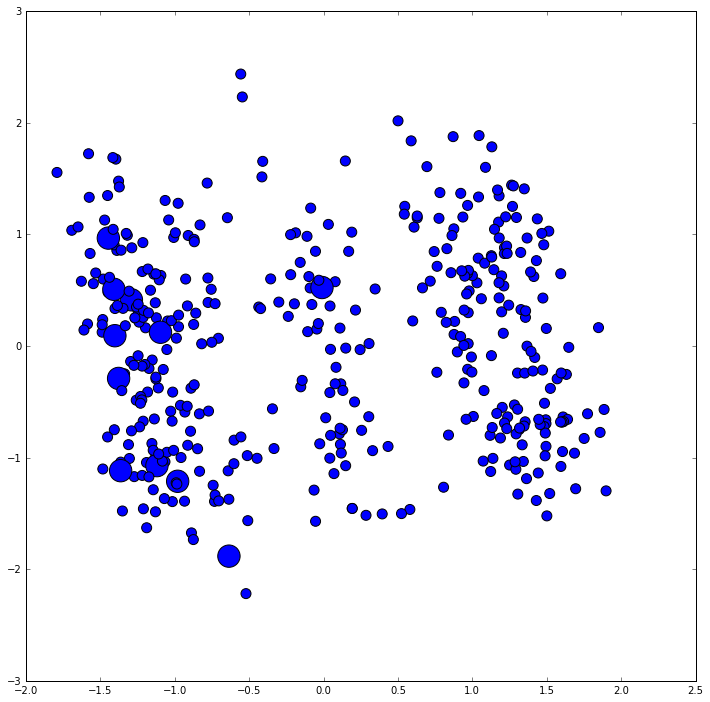

In [122]:
plt.figure(figsize=(12,12))
plt.scatter(SVDproj[:,0],SVDproj[:,1],s=s)
plt.show()